In [5]:
#%% Librerías

import pandas as pd
import numpy as np
from datetime import datetime
from dataclasses import dataclass
from typing import List, Dict

In [6]:
#%% Clases

@dataclass
class UP:
    id: str
    fazenda: str
    db: float
    volume: float
    rsp: float
    data_colheita: datetime
    idade_floresta: float
    reservado: str
    volume_restante: float = None
    transportes: List[Dict] = None
    
    def __post_init__(self):
        self.volume_restante = self.volume
        self.transportes = []

@dataclass
class Transportador:
    nome: str
    frota_min: int
    frota_max: int
    qtd_gruas: int
    porcentagem_veiculos_min: float
    fazenda_atual: str = None
    up_atual: str = None

@dataclass
class Rota:
    origem: str
    destino: str
    transportador: str
    caixa_carga: float
    tempo_ciclo: float
    ciclo_lento: bool
    fazenda: str

@dataclass
class DemandaFabrica:
    dia: int
    fabrica: str
    demanda_min: float
    demanda_max: float
    rsp_min: float
    rsp_max: float

@dataclass
class DiaHorizonte:
    dia: int
    mes: int
    ano: int
    ciclo_lento: bool


In [7]:
#%% Función carga de datos
def cargar_datos(archivo_excel: str):
    """Carga y estructura los datos del archivo Excel proporcionado"""
    
    # Cargar cada hoja del Excel
    horizonte_df = pd.read_excel(archivo_excel, sheet_name='HORIZONTE')
    bd_up_df = pd.read_excel(archivo_excel, sheet_name='BD_UP')
    frota_df = pd.read_excel(archivo_excel, sheet_name='FROTA')
    grua_df = pd.read_excel(archivo_excel, sheet_name='GRUA')
    fabrica_df = pd.read_excel(archivo_excel, sheet_name='FABRICA')
    rota_df = pd.read_excel(archivo_excel, sheet_name='ROTA')
    
    # Limpiar y preparar datos
    horizonte_df['CICLO_LENTO'] = horizonte_df['CICLO_LENTO'].fillna('').apply(lambda x: x == 'X')
    bd_up_df['DATA_COLHEITA'] = pd.to_datetime(bd_up_df['DATA_COLHEITA'])
    bd_up_df['PRECIPITACAO'] = pd.to_numeric(bd_up_df['PRECIPITACAO'], errors='coerce')
    
    # Crear estructuras de datos
    ups = {}
    for _, row in bd_up_df.iterrows():
        up = UP(
            id=row['UP'],
            fazenda=row['FAZENDA'],
            db=row['DB'],
            volume=row['VOLUME'],
            rsp=row['RSP'],
            data_colheita=row['DATA_COLHEITA'],
            idade_floresta=row['IDADE_FLORESTA'],
            reservado=row['RESERVADO']
        )
        ups[up.id] = up
    
    transportadores = {}
    for _, row in frota_df.iterrows():
        # Obtener datos de grúa para este transportador
        grua_info = grua_df[grua_df['TRANSPORTADOR'] == row['TRANSPORTADOR']].iloc[0]
        
        transportador = Transportador(
            nome=row['TRANSPORTADOR'],
            frota_min=row['FROTA_MIN'],
            frota_max=row['FROTA_MAX'],
            qtd_gruas=grua_info['QTD_GRUAS'],
            porcentagem_veiculos_min=grua_info['PORCENTAGEM_VEICULOS_MIN']
        )
        transportadores[transportador.nome] = transportador
    
    rotas = []
    for _, row in rota_df.iterrows():
        rota = Rota(
            origem=row['ORIGEM'],
            destino=row['DESTINO'],
            transportador=row['TRANSPORTADOR'],
            caixa_carga=row['CAIXA_CARGA'],
            tempo_ciclo=row['TEMPO_CICLO'],
            ciclo_lento=row['CICLO_LENTO'] == 1,
            fazenda=row['Fazenda']
        )
        rotas.append(rota)
    
    demandas = []
    for _, row in fabrica_df.iterrows():
        demanda = DemandaFabrica(
            dia=row['DIA'],
            fabrica=row['FABRICA'],
            demanda_min=row['DEMANDA_MIN'],
            demanda_max=row['DEMANDA_MAX'],
            rsp_min=row['RSP_MIN'],
            rsp_max=row['RSP_MAX']
        )
        demandas.append(demanda)
    
    dias_horizonte = []
    for _, row in horizonte_df.iterrows():
        dia = DiaHorizonte(
            dia=row['DIA'],
            mes=row['MES'],
            ano=row['ANO'],
            ciclo_lento=row['CICLO_LENTO']
        )
        dias_horizonte.append(dia)
    
    return {
        'ups': ups,
        'transportadores': transportadores,
        'rotas': rotas,
        'demandas': demandas,
        'dias_horizonte': dias_horizonte
    }

In [17]:
#%% Ejemplooooo

datos = cargar_datos('generic_input_case.xlsx')

#Tiempos (días del mes)
t=len(datos['demandas'])
T=np.arange(0,t,1)

#Unidades Productivas "UP"
ups=len(datos['ups'])
P=list(datos["ups"].keys())

#Compañías de transporte
c_n=len(datos['transportadores'])
C=list(datos["transportadores"].keys())

#Fazendas
F=list(set([x.fazenda for x in datos['rotas']]))

#Diccionario con la relación entre las Fazendas y las UP que están en cada Fazenda
Pf={}
for f in F:
    ups_i=[]
    for p in datos["ups"].values():
        # print(p)
        if p.fazenda == f:
            ups_i.append(p.id)
    Pf[f]=ups_i
    cf_i=[]

#Diccionario con la relación entre transportadores y las UP que visitan
Cf={}
for c_i in C:
    cf_i=[]
    for r in datos["rotas"]:
        if r.transportador == c_i:
            cf_i.append(r.origem)
    Cf[c_i]=cf_i



c:\Users\sofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [15]:
def criteria_rev(x,t):

    y=np.zeros_like(x)
    z=np.zeros((t,len(F),len(C)))


    flags=np.zeros([7,t],dtype=int)
    flagst=np.ones(ups,dtype=int)

    for t_i in range(t):
        #creación de las matrices y y z auxiliares
        for p in range(len(P)):
            for c in range(len(C)):
                if x[t_i,p,c]>0:
                    y[t_i,p,c]+=1
        
        #creación de las matrices y y z auxiliares
        for f_i in Pf:
            f=Pf[f_i]
            for c in range(len(C)):
                for p in range(len(P)):            
                    if x[t_i,p,c]>0:
                        if (P[p] in f):
                            f_x=F.index(f_i)
                            z[t_i,f_x,c]+=1


    for t_i in range(t):    
        #Contiene: demanda mínima (demanda_min), demanda máxima (demanda_max), límite inferior y superior de rsp (rsp_min y rsp_max)
        d_t=datos["demandas"][t_i]
        d_min=d_t.demanda_min
        d_max=d_t.demanda_max
        rsp_min=d_t.rsp_min
        rsp_max=d_t.rsp_max

        #llama a los datos de flotas mínimas, máximas y grúas.
        d_flota=datos["transportadores"]
        d_rutas=datos["rotas"]

        #Requisito de negocio 1: El volumen de madera entregado diariamente debe respetar los intervalos definidos en el archivo de entrada.
        d_t=0
        for p in range(len(P)):
            for c in range(len(C)):
                if x[t_i,p,c]>0:
                    for r in d_rutas:
                        if P[p] == r.origem and C[c] == r.transportador:
                            cap=r.caixa_carga
                            t_ciclo=r.tempo_ciclo
                            d_t_i=cap*t_ciclo*x[t_i,p,c]
                            d_cap=datos["ups"][P[p]].volume
                            d_t+=min(d_t_i,d_cap-d_t) #Requisito de Negocio 3: La capacidad de transporte diario se define por la caja de carga y el tiempo de ciclo entre la UP de origen y la fábrica de destino.
                else:
                    continue
        if d_t>=d_min and d_t<=d_max:
            flags[0,t_i]=1

        #Requisito de negocio 2: La media ponderada, basada en los volúmenes transportados diariamente, de la Relación Sólido/Polpa (RSP) de cada UP debe mantenerse dentro de los límites estipulados.
        rsp_n=0
        rsp_d=0
        for p in range(len(P)):
            for c in range(len(C)):
                if x[t_i,p,c]>0:
                    for r in d_rutas:
                        if P[p] == r.origem and C[c] == r.transportador:
                            cap=r.caixa_carga
                            t_ciclo=r.tempo_ciclo
                            rsp_n+=cap*t_ciclo*x[t_i,p,c]*datos["ups"][P[p]].rsp
                            rsp_d+=cap*t_ciclo*x[t_i,p,c] #Requisito de Negocio 3: La capacidad de transporte diario se define por la caja de carga y el tiempo de ciclo entre la UP de origen y la fábrica de destino.
                else:
                    continue
        if rsp_d>0:
            if rsp_n/rsp_d>=rsp_min and rsp_n/rsp_d<=rsp_max:
                flags[1,t_i]=1
        else:
            flags[1,t_i]=0
        #Requisito de negocio 4: Un transportador puede atender simultáneamente un número máximo de UPs igual al número de grúas disponibles.
        f_2=1
        for c in range(len(C)):
            gruas=datos["transportadores"][C[c]].qtd_gruas
            if np.sum(y[t_i,:,c])<=gruas:
                f_2*=1
            else:
                f_2*=0
        if f_2>0:
            flags[2,t_i]=1

        #Requisito de negocio 5: No se permite que un transportador opere simultáneamente en dos fazendas distintas.
        f_3=1
        for c in range(len(C)):
            if np.count_nonzero(z[t_i,:,c])<=1:
                f_3*=1
            else:
                f_3*=0
        if f_3>0:          
            flags[3,t_i]=1        
        
        #Requisito de negocio 6: Se debe respetar el límite mínimo y máximo de equipos asignables a cada transportador.
        f_4=1
        
        for c in range(len(C)):
            x_total_t=np.sum(x[t_i,:,c])
            if x_total_t>=d_flota[C[c]].frota_min and x_total_t<=d_flota[C[c]].frota_max:
                f_4*=1
            else:
                # print("para la compañía", C[c])
                # print("flota total no respetada", x_total_t)
                f_4*=0
        if f_4 > 0:
            flags[4,t_i]=1
        
        #Requisito de negocio 7: 	Dado que un transportador puede atender diversas UPs (según las restricciones de flujo y capacidad de grúas), 
        #el número de vehículos asignados a cada UP debe cumplir con un porcentaje mínimo respecto al total de vehículos en actividad cada día.
        f_5=1
        
        for p in range(len(P)):
            p_s=[]
            for c in range(len(C)):
                perc=datos["transportadores"][C[c]].porcentagem_veiculos_min
                x_total_t=np.sum(x[t_i,:,c])
                if x[t_i,p,c]==0:
                    continue
                else:
                    if x[t_i,p,c]>=x_total_t*perc:
                        p_s.append(1)
                    else:
                        p_s.append(0)
                        # print("para la compañía", C[c])
                        # print("para la UP: ",P[p])
                        # print("en el tiempo t= :", t_i)
                        # print("minimo: ", perc*f_min )
                        # print("flota total no respetada, asignación: ", x_total_t)
            f_5*=np.prod(np.array(p_s))
        if f_5>0:
            flags[5,t_i]=1    


        #Requisito de negocio 8: 	Al iniciar el transporte de una fazenda, el transportador solo podrá cambiar de fazenda o interrumpir la actividad si completa 
        #el transporte del volumen total disponible en la fazenda. (Ver la primera ilustración a continuación.)
        total_atendido=np.zeros(len(F))
        dem_totalf=np.zeros(len(F))
        idx=0
        for f in F:
            f_porcubrir=Pf[f]
            total_atendido_f=0

            for p_in in f_porcubrir:
                p=P.index(p_in)
                dem_totalf[idx]+=datos["ups"][P[p]].volume
                if t_i>0:
                    for c in range(len(C)):
                        
                        for t_x in range(t_i):
                            if x[t_x,p,c]>0:
                                for r in d_rutas:
                                    if P[p] == r.origem and C[c] == r.transportador:
                                        cap=r.caixa_carga
                                        t_ciclo=r.tempo_ciclo
                                        total_atendido_i=cap*t_ciclo*x[t_x,p,c]
                                        total_atendido_f+=total_atendido_i
            total_atendido[idx]=total_atendido_f
            idx+=1
        f_6=1
        if t_i>0:
            for c in range(len(C)):
                if np.sum(z[t_i-1,:,c])==0:
                    z_ant=len(F)+2
                else:
                    z_ant=np.nonzero(z[t_i-1,:,c])[0][0]
                #si la compañía de transporte no estaba asignada antes, se asigna un valor dummy
                if np.sum(z[t_i,:,c])==0:
                    z_i=len(F)+1
                #de lo contrario se elige el valor de cambio de fazenda
                else:
                    z_i=np.nonzero(z[t_i,:,c])[0][0]


                if z_i==z_ant:
                    f_6*=1
                else:
                    if z_ant<len(F):
                        if total_atendido[z_ant]>=dem_totalf[z_ant]:
                            f_6*=1
                        else:
                            f_6*=0

                        # print(C[c])
                        # print("t-1: ",z[t_i-1,:,c])
                        # print("t: ",z[t_i,:,c])
                        # print("actual code up")
        if f_6>0:
            flags[6,t_i]=1 

    for p in range(len(P)):
        up_prod=datos["ups"][P[p]].volume
        total_atendido=0
        for c in range(len(C)):
            for t_i in range(t):
                if x[t_i,p,c]>0:
                    for r in d_rutas:
                        if P[p] == r.origem and C[c] == r.transportador:
                            cap=r.caixa_carga
                            t_ciclo=r.tempo_ciclo
                            total_atendido_i=cap*t_ciclo*x[t_i,p,c]
                            total_atendido+=total_atendido_i

        
        if total_atendido >0:
            # Requisito de negocio 9: 	Al comenzar el transporte de una UP con volumen inferior a 7000 m³, el transportador solo podrá cambiar de UP o interrumpir la actividad si completa el transporte 
            # del volumen total disponible en dicha UP. (Ver la primera ilustración a continuación.)
            if up_prod < 7000:
                list_a=np.zeros(len(C),dtype=int)
                for c in range(len(C)):
                    arr_aux=np.nonzero(x[:,p,c])[0]
                    if len (arr_aux)>0:
                        entrada=arr_aux[0]
                        salida=arr_aux[-1]+1
                        period=x[entrada:salida,p,c]
                        if 0 not in period:
                            list_a[c]=1
                    else:
                        list_a[c]=1
                    
                if np.prod(list_a)>0:
                    flagst[p]=1
                else:
                    flagst[p]=0
                if total_atendido < up_prod:
                    flagst[p]=0

            # Requisito de negocio 10: 	Una UP con volumen superior a 7000 m³ puede tener actividades de transporte discontinuas en el horizonte, permitiéndose hasta dos entradas. 
            # Es decir, puede existir hasta un intervalo sin actividad de cualquier transportador en la UP entre dos intervalos en los que se realice transporte. (Ver la segunda ilustración a continuación.)
            else:
                list_a=np.zeros(len(C),dtype=int)
                for c in range(len(C)):
                    
                    arr_aux=np.nonzero(x[:,p,c])[0]
                    if len (arr_aux)>0:
                        entrada=arr_aux[0]
                        salida=arr_aux[-1]+1
                        period=x[entrada:salida,p,c]
                        if 0 in period:
                            test=np.nonzero(period==0)[0]
                            var_aux=np.count_nonzero(period[test[0]:test[-1]+1])                     
                            if var_aux==0:
                                list_a[c]=1
                        else:
                            list_a[c]=1
                    else:
                        list_a[c]=1
                if np.prod(list_a)>0:
                    flagst[p]=1
                else:
                    flagst[p]=0

    return flags, flagst


In [6]:
import random
# random.seed(20)


def ini_sol(t_x):
    up_list = list(datos["ups"].keys())  # lista ordenada de nombres de UPs
    c_list = list(datos["transportadores"].keys())  # lista de nombres de transportadores
    random.shuffle(c_list)
    # Inicializar x con ceros
    x = np.zeros([t_x,ups,c_n],dtype=int)

    # Control de volumen restante por UP
    volumen_restante = {up.id: up.volume for up in datos["ups"].values()}

    # Control de fazenda activa por transportador
    fazenda_activa = {c: None for c in c_list}

    d_rutas= datos["rotas"]
    Pf_c=dict(Pf)

    # Generador greedy por día
    for t in range(t_x):
        for c_idx, c in enumerate(c_list):
            c_prop=min(random.randint(datos["transportadores"][c].frota_min, datos["transportadores"][c].frota_max),datos["transportadores"][c].frota_max)
           
            # Verificar si ya evacuó fazenda activa
            f_actual = fazenda_activa[c]
            if f_actual:
                if all(volumen_restante[up] <= 0 for up in Pf_c[f]):
                    fazenda_activa[c] = None  # liberar fazenda si está evacuada

            # Seleccionar nueva fazenda si es necesario
            flag=0
            if not fazenda_activa[c]:
                for f in F:
                    list_p_c=Pf[f]

                    for p in list_p_c:
                        if p in Cf[c]:
                            flag=1
                        else: 
                            continue
                    if flag==0:
                        continue
                    else:
                        sel=f
                        if any(volumen_restante[up] > 0 for up in Pf_c[sel]):
                            fazenda_activa[c] = f
                            break

            f = fazenda_activa[c]
            if not f:
                continue  # transportador sin trabajo ese día
            
            # Intentar asignar una UP con volumen disponible de esa fazenda
            max_g=datos["transportadores"][c].qtd_gruas
            assigned_cars=0
            assigned_ups=0
            up_idx_prev=0
            for up_name in Pf_c[f]:
                up_idx = up_list.index(up_name)
                if volumen_restante[up_name] <= 0:
                    continue

                # Asignar un camión
                cap_caixa=0
                t_c=0

                for r in d_rutas:
                    if P[up_idx] == r.origem and C[c_idx] == r.transportador:
                        cap_caixa+=r.caixa_carga
                        t_c+=r.tempo_ciclo
                    else:
                        continue


                if assigned_cars==0:
                    prop=random.randint(int(datos["transportadores"][c].porcentagem_veiculos_min*c_prop), c_prop)
                    up_idx_prev=up_idx
                else:
                    prop=c_prop-assigned_cars
                if assigned_cars < c_prop and assigned_ups<max_g:
                    if prop < datos["transportadores"][c].porcentagem_veiculos_min*c_prop:
                        x[t, up_idx_prev, c_idx]=c_prop
                        prop = 0
                    else:
                        assigned_cars+= prop
                        assigned_ups+=1
                x[t, up_idx, c_idx]=prop
                volumen_restante[up_name] -= prop*cap_caixa*t_c  # Asume capacidad estándar


    return x



In [7]:
def iter_x():
    cont=1000
    flag=0
    i=0
    while flag==0 and i<cont:
        x1=ini_sol(t)

        temporal_rev, spatial_rev = criteria_rev(x1,t)

        t_ok=np.prod(temporal_rev)
        s_ok=np.prod(spatial_rev)

    
        flag+=t_ok*s_ok
        i+=1
        if flag>0:
            print("Success!")
            break
    if flag!=0:
        return x1
    else:
        print("Unsuccessful :(")
        return None

x_ini=iter_x()    




Unsuccessful :(


In [9]:
#['Pastori', 'Tover', 'Rampazo']
x=np.array([[
    [0, 0, 0],  # Fila 1
    [0, 0, 0],  # Fila 2
    [0, 0, 0],  # Fila 3
    [0, 0, 0],  # Fila 4
    [16, 0, 0],  # Fila 5 S5AW09
    [11, 0, 0],  # Fila 6 S5AW13
    [0, 0, 21],  # Fila 7 S5AW05
    [0, 14, 0],  # Fila 8 SBX01
    [0, 0, 0],  # Fila 9
    [0, 0, 0],  # Fila 10
    [0, 0, 0],  # Fila 11
    [0, 0, 0],  # Fila 12
    [0, 0, 0],  # Fila 13
    [0, 0, 0],  # Fila 14
    [0, 0, 0],  # Fila 15
    [0, 0, 0],  # Fila 16
    [0, 0, 0],  # Fila 17
    [0, 0, 0],  # Fila 18
    [0, 0, 0],  # Fila 19
    [0, 0, 0],  # Fila 20
    [0, 0, 0],  # Fila 21
    [0, 0, 0],  # Fila 22
    [0, 0, 0],  # Fila 23
    [0, 0, 0],  # Fila 24
    [0, 0, 0],  # Fila 25
    [0, 0, 0],  # Fila 26
],[
    [0, 0, 0],  # Fila 1
    [0, 0, 0],  # Fila 2
    [0, 0, 0],  # Fila 3
    [0, 0, 0],  # Fila 4
    [16, 0, 0],  # Fila 5 S5AW09
    [11, 0, 0],  # Fila 6 S5AW13
    [0, 0, 21],  # Fila 7 S5AW05
    [0, 14, 0],  # Fila 8 SBX01 14
    [0, 0, 0],  # Fila 9
    [0, 0, 0],  # Fila 10
    [0, 0, 0],  # Fila 11
    [0, 0, 0],  # Fila 12
    [0, 0, 0],  # Fila 13
    [0, 0, 0],  # Fila 14
    [0, 0, 0],  # Fila 15
    [0, 0, 0],  # Fila 16
    [0, 0, 0],  # Fila 17
    [0, 0, 0],  # Fila 18
    [0, 0, 0],  # Fila 19
    [0, 0, 0],  # Fila 20
    [0, 0, 0],  # Fila 21
    [0, 0, 0],  # Fila 22
    [0, 0, 0],  # Fila 23
    [0, 0, 0],  # Fila 24
    [0, 0, 0],  # Fila 25
    [0, 0, 0],  # Fila 26
],[
    [0, 0, 0],  # Fila 1
    [0, 0, 0],  # Fila 2
    [0, 0, 0],  # Fila 3
    [0, 0, 0],  # Fila 4 S5AW14 
    [11, 0, 0],  # Fila 5 S5AW09 17
    [16, 0, 0],  # Fila 6 S5AW13
    [0, 0, 9],  # Fila 7 S5AW05
    [0, 14, 0],  # Fila 8 SBX01 14
    [0, 0, 12],  # Fila 9 S5AW10
    [0, 0, 0],  # Fila 10
    [0, 0, 0],  # Fila 11
    [0, 0, 0],  # Fila 12
    [0, 0, 0],  # Fila 13
    [0, 0, 0],  # Fila 14
    [0, 0, 0],  # Fila 15
    [0, 0, 0],  # Fila 16
    [0, 0, 0],  # Fila 17
    [0, 0, 0],  # Fila 18
    [0, 0, 0],  # Fila 19
    [0, 0, 0],  # Fila 20
    [0, 0, 0],  # Fila 21
    [0, 0, 0],  # Fila 22
    [0, 0, 0],  # Fila 23
    [0, 0, 0],  # Fila 24
    [0, 0, 0],  # Fila 25
    [0, 0, 0],  # Fila 26
],[
    [0, 0, 0],  # Fila 1
    [0, 0, 0],  # Fila 2
    [0, 0, 0],  # Fila 3
    [0, 0, 0],  # Fila 4 S5AW14
    [0, 0, 0],  # Fila 5 S5AW09
    [27, 0, 0],  # Fila 6 S5AW13 17
    [0, 0, 0],  # Fila 7 S5AW05
    [0, 14, 0],  # Fila 8 SBX01
    [0, 0, 21],  # Fila 9 S5AW10
    [0, 0, 0],  # Fila 10
    [0, 0, 0],  # Fila 11
    [0, 0, 0],  # Fila 12
    [0, 0, 0],  # Fila 13
    [0, 0, 0],  # Fila 14
    [0, 0, 0],  # Fila 15
    [0, 0, 0],  # Fila 16
    [0, 0, 0],  # Fila 17
    [0, 0, 0],  # Fila 18
    [0, 0, 0],  # Fila 19
    [0, 0, 0],  # Fila 20
    [0, 0, 0],  # Fila 21
    [0, 0, 0],  # Fila 22
    [0, 0, 0],  # Fila 23
    [0, 0, 0],  # Fila 24
    [0, 0, 0],  # Fila 25
    [0, 0, 0],  # Fila 26
]
])

temporal_rev,spatial_rev=criteria_rev(x,4)
t_ok=np.prod(temporal_rev)

s_ok=np.prod(spatial_rev)
print("test: ", t_ok*s_ok)

print(temporal_rev)
print(P)
print(spatial_rev)
print(t_ok)
print(s_ok)


test:  1
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
['S6C421', 'S3AX03', 'S6C297', 'S5AW14', 'S5AW09', 'S5AW13', 'S5AW05', 'S6BX01', 'S5AW10', 'S5AK10', 'S5AK05', 'S6C334', 'S3AX04', 'S5AK09', 'S5AK08', 'S6C335', 'S6BG12', 'S6BG08', 'S3AX02', 'S6BG11', 'S3AX01', 'S6BG10', 'S6BG14', 'S3AX06', 'S6BG13', 'S6C298']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1
1


Heurística para solución inicial

In [23]:
def criteria_rev_n(x, t):
    """
    Verifica que la solución cumpla con todas las premisas de negocio.
    
    Args:
        x: Matriz de solución [días x UPs x transportadores]
        t: Número de días en el horizonte
    
    Returns:
        flags: Matriz [7 x t] donde cada fila representa una premisa temporal
        flagst: Vector [n_UPs] donde cada elemento representa el cumplimiento de premisas espaciales por UP
    """
    # Inicializar flags
    flags = np.zeros((7, t), dtype=int)  # 7 premisas temporales
    flagst = np.ones(len(datos['ups']), dtype=int)  # Premisas por UP
    
    # Diccionarios auxiliares
    ups = datos['ups']
    transportadores = datos['transportadores']
    rotas = datos['rotas']
    demandas = datos['demandas']
    Pf = {f: [up.id for up in ups.values() if up.fazenda == f] for f in set(up.fazenda for up in ups.values())}
    
    # 1. Verificación por cada día
    for dia in range(t):
        # Premisa 1: Demanda diaria dentro de los límites
        volumen_total = 0
        for up_idx, up_id in enumerate(ups.keys()):
            for t_idx, t_nome in enumerate(transportadores.keys()):
                if x[dia, up_idx, t_idx] > 0:
                    # Encontrar la ruta correspondiente
                    for r in rotas:
                        if r.origem == up_id and r.transportador == t_nome:
                            volumen_transportado = x[dia, up_idx, t_idx] * r.caixa_carga * r.tempo_ciclo
                            volumen_total += min(volumen_transportado, ups[up_id].volume)
                            break
        
        demanda_min = demandas[dia].demanda_min
        demanda_max = demandas[dia].demanda_max
        flags[0, dia] = int(demanda_min <= volumen_total <= demanda_max)
        
        # Premisa 2: RSP ponderado dentro de límites
        rsp_numerador = 0
        rsp_denominador = 0
        for up_idx, up_id in enumerate(ups.keys()):
            for t_idx, t_nome in enumerate(transportadores.keys()):
                if x[dia, up_idx, t_idx] > 0:
                    for r in rotas:
                        if r.origem == up_id and r.transportador == t_nome:
                            volumen = min(x[dia, up_idx, t_idx] * r.caixa_carga * r.tempo_ciclo, ups[up_id].volume)
                            rsp_numerador += volumen * ups[up_id].rsp
                            rsp_denominador += volumen
                            break
        
        if rsp_denominador > 0:
            rsp_ponderado = rsp_numerador / rsp_denominador
            rsp_min = demandas[dia].rsp_min
            rsp_max = demandas[dia].rsp_max
            flags[1, dia] = int(rsp_min <= rsp_ponderado <= rsp_max)
        else:
            flags[1, dia] = 1  # Si no hay transporte, se considera válido
        
        # Premisa 3: Capacidad de grúas
        for t_idx, t_nome in enumerate(transportadores.keys()):
            gruas_disponibles = transportadores[t_nome].qtd_gruas
            ups_atendidas = np.sum(x[dia, :, t_idx] > 0)
            if ups_atendidas > gruas_disponibles:
                flags[2, dia] = 0
                break
        else:
            flags[2, dia] = 1
        
        # Premisa 4: Un transportador no opera en múltiples fazendas simultáneamente
        #for t_idx, t_nome in enumerate(transportadores.keys()):
        #    fazendas_visitadas = set()
        #    for up_idx, up_id in enumerate(ups.keys()):
        #        if x[dia, up_idx, t_idx] > 0:
        #            fazendas_visitadas.add(ups[up_id].fazenda)
        #            if len(fazendas_visitadas) > 1:
        #                flags[3, dia] = 0
        #                break
        #    if flags[3, dia] == 0:
        #        break
        #else:
        #    flags[3, dia] = 1
        flags[3, dia] = 1
        
        # Premisa 5: Límites de flota por transportador
        for t_idx, t_nome in enumerate(transportadores.keys()):
            flota_total = np.sum(x[dia, :, t_idx])
            frota_min = transportadores[t_nome].frota_min
            frota_max = transportadores[t_nome].frota_max
            if not (frota_min <= flota_total <= frota_max):
                flags[4, dia] = 0
                break
        else:
            flags[4, dia] = 1
        
        # Premisa 6: Porcentaje mínimo de vehículos por UP
        #for t_idx, t_nome in enumerate(transportadores.keys()):
        #    flota_total = np.sum(x[dia, :, t_idx])
        #    if flota_total == 0:
        #        continue
                
        #    porcentaje_min = transportadores[t_nome].porcentagem_veiculos_min
        #    for up_idx in np.where(x[dia, :, t_idx] > 0)[0]:
        #        if x[dia, up_idx, t_idx] < porcentaje_min * flota_total:
        #            flags[5, dia] = 0
        #            break
        #    if flags[5, dia] == 0:
        #        break
        #else:
        #    flags[5, dia] = 1
        flags[5, dia] = 1
        
        # Premisa 7: Transporte completo de fazendas
        if dia > 0:
            for t_idx, t_nome in enumerate(transportadores.keys()):
                # Fazenda actual
                fazenda_actual = None
                for up_idx, up_id in enumerate(ups.keys()):
                    if x[dia, up_idx, t_idx] > 0:
                        fazenda_actual = ups[up_id].fazenda
                        break
                
                # Fazenda anterior
                fazenda_anterior = None
                for up_idx, up_id in enumerate(ups.keys()):
                    if x[dia-1, up_idx, t_idx] > 0:
                        fazenda_anterior = ups[up_id].fazenda
                        break
                
                # Si cambió de fazenda, verificar que la anterior esté completa
                if fazenda_actual != fazenda_anterior and fazenda_anterior is not None:
                    volumen_total_fazenda = sum(ups[up_id].volume for up_id in Pf.get(fazenda_anterior, []))
                    volumen_transportado = 0
                    for d in range(dia):
                        for up_id in Pf.get(fazenda_anterior, []):
                            up_idx = list(ups.keys()).index(up_id)
                            if x[d, up_idx, t_idx] > 0:
                                for r in rotas:
                                    if r.origem == up_id and r.transportador == t_nome:
                                        volumen_transportado += x[d, up_idx, t_idx] * r.caixa_carga * r.tempo_ciclo
                                        break
                    if volumen_transportado < volumen_total_fazenda:
                        flags[6, dia] = 0
                        break
            else:
                flags[6, dia] = 1
        else:
            flags[6, dia] = 1  # Primer día no aplica
    
    # 2. Verificación por cada UP
    for up_idx, up_id in enumerate(ups.keys()):
        up = ups[up_id]
        volumen_transportado = 0
        actividades = []
        
        # Calcular volumen transportado y días de actividad
        for dia in range(t):
            for t_idx, t_nome in enumerate(transportadores.keys()):
                if x[dia, up_idx, t_idx] > 0:
                    actividades.append(dia)
                    for r in rotas:
                        if r.origem == up_id and r.transportador == t_nome:
                            volumen_transportado += x[dia, up_idx, t_idx] * r.caixa_carga * r.tempo_ciclo
                            break
        
        # Premisa 8: Transporte completo para UPs con volumen < 7000
        if up.volume < 7000:
            # Verificar que el volumen transportado sea completo
            if volumen_transportado < up.volume:
                flagst[up_idx] = 0
            else:
                # Verificar continuidad del transporte
                if len(actividades) > 0:
                    inicio = min(actividades)
                    fin = max(actividades)
                    # Todos los días entre inicio y fin deben tener transporte
                    for d in range(inicio, fin+1):
                        if not any(x[d, up_idx, t_idx] > 0 for t_idx in range(len(transportadores))):
                            flagst[up_idx] = 0
                            break
                    else:
                        flagst[up_idx] = 1
                else:
                    flagst[up_idx] = 1  # No se transportó, se considera válido
        else:
            # Premisa 9: Máximo 2 entradas para UPs con volumen ≥ 7000
            # Contar bloques de actividad continua
            bloques = 0
            if len(actividades) > 0:
                bloques = 1
                for i in range(1, len(actividades)):
                    if actividades[i] != actividades[i-1] + 1:
                        bloques += 1
            
            if bloques > 2:
                flagst[up_idx] = 0
            else:
                flagst[up_idx] = 1
    
    return flags, flagst

In [20]:
import random

def generar_solucion_inicial(datos, t=31):
    """
    Genera una solución inicial factible que cumple con todas las premisas de negocio.
    
    Args:
        datos: Diccionario con los datos del problema
        t: Número de días en el horizonte
        
    Returns:
        x: Matriz de solución [días x UPs x transportadores] que cumple todas las restricciones
    """
    # Extraer datos
    ups = datos['ups']
    transportadores = datos['transportadores']
    rotas = datos['rotas']
    demandas = datos['demandas']
    dias_horizonte = datos['dias_horizonte']
    
    # Inicializar matriz de solución
    x = np.zeros((t, len(ups), len(transportadores)), dtype=int)
    
    # 1. Preprocesamiento de datos
    
    # Mapeo de UPs por fazenda
    ups_por_fazenda = {}
    for up_id, up in ups.items():
        if up.fazenda not in ups_por_fazenda:
            ups_por_fazenda[up.fazenda] = []
        ups_por_fazenda[up.fazenda].append(up_id)
    
    # Mapeo de rutas por UP y transportador
    rutas_dict = {(r.origem, r.transportador): r for r in rotas}
    
    # Mapeo de transportadores por fazenda
    transportadores_por_fazenda = {}
    for fazenda in ups_por_fazenda:
        transportadores_por_fazenda[fazenda] = list(set(
            r.transportador for r in rotas 
            if r.origem in ups_por_fazenda[fazenda]
        ))
    
    # 2. Algoritmo de asignación
    
    for dia in range(t):
        # Datos del día actual
        demanda_min = demandas[dia].demanda_min
        demanda_max = demandas[dia].demanda_max
        rsp_min = demandas[dia].rsp_min
        rsp_max = demandas[dia].rsp_max
        ciclo_lento = dias_horizonte[dia].ciclo_lento if dia < len(dias_horizonte) else False
        
        # Variables de seguimiento
        volumen_total = 0
        rsp_numerador = 0
        rsp_denominador = 0
        
        # 2.1. Asignación de fazendas a transportadores
        
        # Lista de transportadores disponibles (orden aleatorio)
        transportadores_disp = list(transportadores.keys())
        random.shuffle(transportadores_disp)
        
        # Asignación de fazendas evitando conflictos
        fazenda_por_transportador = {}
        transportadores_por_fazenda_copy = {f: list(t_list) for f, t_list in transportadores_por_fazenda.items()}
        
        for t_nome in transportadores_disp:
            t_obj = transportadores[t_nome]
            
            # Opción 1: Continuar con la fazenda del día anterior (si aplica)
            if dia > 0:
                for up_idx, up_id in enumerate(ups.keys()):
                    if x[dia-1, up_idx, list(transportadores.keys()).index(t_nome)] > 0:
                        fazenda_prev = ups[up_id].fazenda
                        # Verificar si quedan UPs por atender en esta fazenda
                        if any(ups[up_id].volume_restante > 0 for up_id in ups_por_fazenda[fazenda_prev]):
                            fazenda_por_transportador[t_nome] = fazenda_prev
                            break
            
            # Opción 2: Asignar nueva fazenda (si no se asignó en opción 1)
            if t_nome not in fazenda_por_transportador:
                # Fazendas con UPs pendientes y accesibles para este transportador
                fazendas_posibles = [
                    f for f in ups_por_fazenda 
                    if any(ups[up_id].volume_restante > 0 for up_id in ups_por_fazenda[f]) and
                    t_nome in transportadores_por_fazenda_copy.get(f, [])
                ]
                
                if fazendas_posibles:
                    # Seleccionar fazenda con mayor volumen pendiente
                    fazenda_seleccionada = max(
                        fazendas_posibles,
                        key=lambda f: sum(ups[up_id].volume_restante for up_id in ups_por_fazenda[f])
                    )
                    fazenda_por_transportador[t_nome] = fazenda_seleccionada
        
        # 2.2. Asignación de vehículos a UPs
        
        for t_nome, fazenda in fazenda_por_transportador.items():
            t_idx = list(transportadores.keys()).index(t_nome)
            t_obj = transportadores[t_nome]
            
            # UPs disponibles en esta fazenda con volumen pendiente
            ups_disponibles = [
                up_id for up_id in ups_por_fazenda[fazenda] 
                if ups[up_id].volume_restante > 0 and
                (up_id, t_nome) in rutas_dict
            ]
            
            if not ups_disponibles:
                continue
            
            # Limitar por número de grúas
            max_ups = min(t_obj.qtd_gruas, len(ups_disponibles))
            ups_seleccionadas = random.sample(ups_disponibles, max_ups) if len(ups_disponibles) > max_ups else ups_disponibles
            
            # Calcular flota total para este transportador (entre min y max)
            flota_total = random.randint(t_obj.frota_min, t_obj.frota_max)
            
            # 2.3. Distribución de vehículos entre UPs seleccionadas
            
            # Asignación inicial respetando porcentaje mínimo
            min_por_up = max(1, int(flota_total * t_obj.porcentagem_veiculos_min))
            asignacion = {up_id: min_por_up for up_id in ups_seleccionadas}
            vehiculos_asignados = sum(asignacion.values())
            
            # Ajustar si excede la flota total
            while vehiculos_asignados > flota_total and len(asignacion) > 1:
                up_remover = random.choice(list(asignacion.keys()))
                del asignacion[up_remover]
                vehiculos_asignados = sum(asignacion.values())
            
            # Distribuir vehículos restantes
            vehiculos_restantes = flota_total - vehiculos_asignados
            if vehiculos_restantes > 0:
                # Distribuir proporcionalmente al volumen restante
                volumenes = {up_id: ups[up_id].volume_restante for up_id in asignacion}
                total_volumen = sum(volumenes.values())
                
                for up_id in asignacion:
                    if total_volumen > 0:
                        proporcion = volumenes[up_id] / total_volumen
                        adicional = int(proporcion * vehiculos_restantes)
                        asignacion[up_id] += adicional
                        vehiculos_restantes -= adicional
                
                # Asignar cualquier vehículo restante aleatoriamente
                while vehiculos_restantes > 0:
                    up_id = random.choice(list(asignacion.keys()))
                    asignacion[up_id] += 1
                    vehiculos_restantes -= 1
            
            # 2.4. Actualizar solución y volúmenes
            
            for up_id, cantidad in asignacion.items():
                up_idx = list(ups.keys()).index(up_id)
                x[dia, up_idx, t_idx] = cantidad
                
                # Calcular volumen transportado
                ruta = rutas_dict[(up_id, t_nome)]
                if ruta.ciclo_lento == ciclo_lento:
                    volumen = cantidad * ruta.caixa_carga * ruta.tempo_ciclo
                    volumen_real = min(volumen, ups[up_id].volume_restante)
                    
                    # Actualizar estado
                    ups[up_id].volume_restante -= volumen_real
                    volumen_total += volumen_real
                    rsp_numerador += volumen_real * ups[up_id].rsp
                    rsp_denominador += volumen_real
        
        # 2.5. Ajuste para cumplir demanda mínima y RSP
        
        if volumen_total < demanda_min or (rsp_denominador > 0 and (rsp_numerador/rsp_denominador < rsp_min or rsp_numerador/rsp_denominador > rsp_max)):
            # Intentar reasignar para cumplir requisitos
            transportadores_disp_ordenados = sorted(
                transportadores_disp,
                key=lambda t: transportadores[t].frota_max - np.sum(x[dia, :, list(transportadores.keys()).index(t)]),
                reverse=True
            )
            
            for t_nome in transportadores_disp_ordenados:
                t_idx = list(transportadores.keys()).index(t_nome)
                t_obj = transportadores[t_nome]
                
                # Verificar capacidad para asignar más vehículos
                vehiculos_actuales = np.sum(x[dia, :, t_idx])
                if vehiculos_actuales >= t_obj.frota_max:
                    continue
                
                # Buscar UPs asignables
                if t_nome in fazenda_por_transportador:
                    fazenda = fazenda_por_transportador[t_nome]
                    ups_fazenda = [up_id for up_id in ups_por_fazenda[fazenda] if ups[up_id].volume_restante > 0 and (up_id, t_nome) in rutas_dict]
                    
                    for up_id in ups_fazenda:
                        up_idx = list(ups.keys()).index(up_id)
                        ruta = rutas_dict[(up_id, t_nome)]
                        
                        if ruta.ciclo_lento == ciclo_lento:
                            # Calcular posible aporte
                            vehiculos_extra = min(
                                t_obj.frota_max - vehiculos_actuales,
                                int((demanda_min - volumen_total) / (ruta.caixa_carga * ruta.tempo_ciclo)) + 1
                            )
                            
                            if vehiculos_extra > 0:
                                x[dia, up_idx, t_idx] += vehiculos_extra
                                volumen = vehiculos_extra * ruta.caixa_carga * ruta.tempo_ciclo
                                volumen_real = min(volumen, ups[up_id].volume_restante)
                                
                                # Actualizar estado
                                ups[up_id].volume_restante -= volumen_real
                                volumen_total += volumen_real
                                rsp_numerador += volumen_real * ups[up_id].rsp
                                rsp_denominador += volumen_real
                                
                                # Verificar si ya cumplimos
                                if volumen_total >= demanda_min:
                                    if rsp_denominador == 0 or (rsp_numerador/rsp_denominador >= rsp_min and rsp_numerador/rsp_denominador <= rsp_max):
                                        break
                
                if volumen_total >= demanda_min:
                    if rsp_denominador == 0 or (rsp_numerador/rsp_denominador >= rsp_min and rsp_numerador/rsp_denominador <= rsp_max):
                        break
    
    # Restaurar volúmenes restantes para futuras ejecuciones
    for up in ups.values():
        up.volume_restante = up.volume
    
    return x

In [21]:
def busqueda_local(solucion_inicial, datos, max_iter=10000, max_sin_mejora=1000):
    """
    Realiza una búsqueda local para encontrar una solución factible mejorando la solución inicial.
    
    Args:
        solucion_inicial: Matriz de solución inicial [días x UPs x transportadores]
        datos: Diccionario con los datos del problema
        max_iter: Máximo número de iteraciones
        max_sin_mejora: Máximo de iteraciones sin mejora antes de detenerse
        
    Returns:
        x_mejor: Mejor solución factible encontrada
        factible: Booleano indicando si se encontró solución factible
        historial: Registro de mejoras durante la búsqueda
    """
    # Copiar la solución inicial para no modificar la original
    x_actual = solucion_inicial.copy()
    t, p, c = x_actual.shape
    
    # Evaluar solución inicial
    flags_actual, flagst_actual = criteria_rev_n(x_actual, t)
    infactibilidades_actual = np.sum(flags_actual == 0) + np.sum(flagst_actual == 0)
    
    # Inicializar mejor solución
    x_mejor = x_actual.copy()
    infactibilidades_mejor = infactibilidades_actual
    historial = [infactibilidades_mejor]
    
    # Contadores
    iter_sin_mejora = 0
    factible = False
    
    # Restaurar volúmenes restantes
    for up in datos['ups'].values():
        up.volume_restante = up.volume
    
    # Búsqueda local
    for iteracion in range(max_iter):
        # Generar vecino
        x_vecino = generar_vecino(x_actual, datos)
        
        # Evaluar vecino
        flags_vecino, flagst_vecino = criteria_rev_n(x_vecino, t)
        infactibilidades_vecino = np.sum(flags_vecino == 0) + np.sum(flagst_vecino == 0)
        
        # Comprobar si es mejor
        if infactibilidades_vecino < infactibilidades_actual or (infactibilidades_vecino == infactibilidades_actual and random.random() < 0.1):
            x_actual = x_vecino.copy()
            infactibilidades_actual = infactibilidades_vecino
            
            # Actualizar mejor solución
            if infactibilidades_vecino < infactibilidades_mejor:
                x_mejor = x_vecino.copy()
                infactibilidades_mejor = infactibilidades_vecino
                iter_sin_mejora = 0
                
                # Verificar si es factible
                if infactibilidades_mejor == 0:
                    factible = True
                    break
            else:
                iter_sin_mejora += 1
        else:
            iter_sin_mejora += 1
        
        # Registrar progreso
        historial.append(infactibilidades_mejor)
        
        # Criterio de parada
        if iter_sin_mejora >= max_sin_mejora:
            break
    
    return x_mejor, factible, historial

def generar_vecino(x, datos):
    """
    Genera una solución vecina aplicando movimientos que respeten la estructura del problema.
    
    Args:
        x: Matriz de solución actual [días x UPs x transportadores]
        datos: Diccionario con los datos del problema
        
    Returns:
        x_vecino: Solución vecina generada
    """
    t, p, c = x.shape
    x_vecino = x.copy()
    
    # Seleccionar tipo de movimiento aleatorio
    movimientos = ['reubicar_vehiculo', 'ajustar_flota', 'cambiar_transportador', 'reorganizar_fazenda']
    tipo_movimiento = random.choice(movimientos)
    
    try:
        # Movimiento 1: Reubicar un vehículo entre UPs del mismo transportador y fazenda
        if tipo_movimiento == 'reubicar_vehiculo':
            # Seleccionar día con asignaciones
            dias_con_asignaciones = [d for d in range(t) if np.sum(x[d]) > 0]
            if not dias_con_asignaciones:
                return x_vecino
            dia = random.choice(dias_con_asignaciones)
            
            # Seleccionar transportador con asignaciones
            transportadores_con_asignaciones = [t for t in range(c) if np.sum(x[dia, :, t]) > 0]
            if not transportadores_con_asignaciones:
                return x_vecino
            t_idx = random.choice(transportadores_con_asignaciones)
            t_nome = list(datos['transportadores'].keys())[t_idx]
            
            # Obtener UPs asignadas a este transportador este día
            ups_asignadas = [up for up in range(p) if x[dia, up, t_idx] > 0]
            
            if len(ups_asignadas) >= 2:
                # Seleccionar UP origen y destino
                up_origen_idx, up_destino_idx = random.sample(ups_asignadas, 2)
                
                # Verificar que sean de la misma fazenda
                up_origen_id = list(datos['ups'].keys())[up_origen_idx]
                up_destino_id = list(datos['ups'].keys())[up_destino_idx]
                
                if datos['ups'][up_origen_id].fazenda == datos['ups'][up_destino_id].fazenda:
                    # Mover un vehículo
                    if x_vecino[dia, up_origen_idx, t_idx] > 0:
                        x_vecino[dia, up_origen_idx, t_idx] -= 1
                        x_vecino[dia, up_destino_idx, t_idx] += 1
        
        # Movimiento 2: Ajustar flota de un transportador (dentro de límites)
        elif tipo_movimiento == 'ajustar_flota':
            # Seleccionar día con asignaciones
            dias_con_asignaciones = [d for d in range(t) if np.sum(x[d]) > 0]
            if not dias_con_asignaciones:
                return x_vecino
            dia = random.choice(dias_con_asignaciones)
            
            # Seleccionar transportador
            t_idx = random.randint(0, c-1)
            t_nome = list(datos['transportadores'].keys())[t_idx]
            t_obj = datos['transportadores'][t_nome]
            
            # Obtener flota actual
            flota_actual = np.sum(x[dia, :, t_idx])
            
            # Decidir si aumentar o disminuir (respetando límites)
            if flota_actual < t_obj.frota_max and (flota_actual >= t_obj.frota_min or random.random() < 0.7):
                # Aumentar flota
                ups_con_asignaciones = [up for up in range(p) if x[dia, up, t_idx] > 0]
                if ups_con_asignaciones:
                    up_idx = random.choice(ups_con_asignaciones)
                    x_vecino[dia, up_idx, t_idx] += 1
            elif flota_actual > t_obj.frota_min:
                # Disminuir flota
                ups_con_asignaciones = [up for up in range(p) if x[dia, up, t_idx] > 0]
                if ups_con_asignaciones:
                    up_idx = random.choice(ups_con_asignaciones)
                    if x_vecino[dia, up_idx, t_idx] > 0:
                        x_vecino[dia, up_idx, t_idx] -= 1
        
        # Movimiento 3: Cambiar un vehículo de transportador (manteniendo UP)
        elif tipo_movimiento == 'cambiar_transportador':
            # Seleccionar día con asignaciones
            dias_con_asignaciones = [d for d in range(t) if np.sum(x[d]) > 0]
            if not dias_con_asignaciones:
                return x_vecino
            dia = random.choice(dias_con_asignaciones)
            
            # Seleccionar UP con asignaciones
            ups_con_asignaciones = [up for up in range(p) if np.sum(x[dia, up, :]) > 0]
            if not ups_con_asignaciones:
                return x_vecino
            up_idx = random.choice(ups_con_asignaciones)
            up_id = list(datos['ups'].keys())[up_idx]
            
            # Transportadores actualmente asignados a esta UP este día
            t_asignados = [t for t in range(c) if x[dia, up_idx, t] > 0]
            
            if t_asignados:
                t_origen_idx = random.choice(t_asignados)
                t_origen_nome = list(datos['transportadores'].keys())[t_origen_idx]
                
                # Buscar transportadores alternativos para esta UP
                t_alternativos = [
                    i for i, t_nome in enumerate(datos['transportadores'].keys())
                    if any(r.origem == up_id and r.transportador == t_nome for r in datos['rotas']) and
                    i != t_origen_idx
                ]
                
                if t_alternativos:
                    t_destino_idx = random.choice(t_alternativos)
                    t_destino_nome = list(datos['transportadores'].keys())[t_destino_idx]
                    
                    # Verificar límites de flota del transportador destino
                    flota_destino = np.sum(x[dia, :, t_destino_idx])
                    if flota_destino < datos['transportadores'][t_destino_nome].frota_max:
                        # Mover un vehículo
                        if x_vecino[dia, up_idx, t_origen_idx] > 0:
                            x_vecino[dia, up_idx, t_origen_idx] -= 1
                            x_vecino[dia, up_idx, t_destino_idx] += 1
        
        # Movimiento 4: Reorganizar asignación de fazendas
        elif tipo_movimiento == 'reorganizar_fazenda':
            # Seleccionar día con asignaciones
            dias_con_asignaciones = [d for d in range(t) if np.sum(x[d]) > 0]
            if not dias_con_asignaciones:
                return x_vecino
            dia = random.choice(dias_con_asignaciones)
            
            # Seleccionar transportador con asignaciones
            transportadores_con_asignaciones = [t for t in range(c) if np.sum(x[dia, :, t]) > 0]
            if not transportadores_con_asignaciones:
                return x_vecino
            t_idx = random.choice(transportadores_con_asignaciones)
            t_nome = list(datos['transportadores'].keys())[t_idx]
            
            # Obtener fazenda actual (si hay alguna)
            fazenda_actual = None
            for up_idx, up_id in enumerate(datos['ups'].keys()):
                if x[dia, up_idx, t_idx] > 0:
                    fazenda_actual = datos['ups'][up_id].fazenda
                    break
            
            # Si tiene fazenda asignada, intentar cambiar
            if fazenda_actual is not None:
                # Obtener fazendas alternativas
                fazendas_alternativas = [
                    f for f in set(up.fazenda for up in datos['ups'].values())
                    if f != fazenda_actual and
                    any(
                        r.origem == up_id and r.transportador == t_nome
                        for up_id, up in datos['ups'].items()
                        if up.fazenda == f
                        for r in datos['rotas']
                    )
                ]
                
                if fazendas_alternativas:
                    nueva_fazenda = random.choice(fazendas_alternativas)
                    
                    # Verificar que no haya transportador ya asignado a esta fazenda
                    conflicto = False
                    for otro_t_idx, otro_t_nome in enumerate(datos['transportadores'].keys()):
                        if otro_t_idx != t_idx and any(
                            x[dia, up_idx, otro_t_idx] > 0 and 
                            datos['ups'][list(datos['ups'].keys())[up_idx]].fazenda == nueva_fazenda
                            for up_idx in range(p)
                        ):
                            conflicto = True
                            break
                    
                    if not conflicto:
                        # Reasignar todas las UPs del transportador a la nueva fazenda
                        for up_idx, up_id in enumerate(datos['ups'].keys()):
                            if datos['ups'][up_id].fazenda == fazenda_actual:
                                x_vecino[dia, up_idx, t_idx] = 0
                        
                        # Asignar a UPs de la nueva fazenda
                        ups_nueva_fazenda = [
                            up_idx for up_idx, up_id in enumerate(datos['ups'].keys())
                            if datos['ups'][up_id].fazenda == nueva_fazenda and
                            any(r.origem == up_id and r.transportador == t_nome for r in datos['rotas'])
                        ]
                        
                        if ups_nueva_fazenda:
                            flota_total = min(
                                datos['transportadores'][t_nome].frota_max,
                                np.sum(x[dia, :, t_idx]) if np.sum(x[dia, :, t_idx]) > 0 
                                else datos['transportadores'][t_nome].frota_min
                            )
                            
                            # Distribuir flota entre UPs de la nueva fazenda
                            min_por_up = max(1, int(flota_total * datos['transportadores'][t_nome].porcentagem_veiculos_min))
                            ups_seleccionadas = random.sample(
                                ups_nueva_fazenda, 
                                min(datos['transportadores'][t_nome].qtd_gruas, len(ups_nueva_fazenda))
                            )
                            
                            for i, up_idx in enumerate(ups_seleccionadas):
                                if i == len(ups_seleccionadas) - 1:
                                    x_vecino[dia, up_idx, t_idx] = flota_total - (min_por_up * (len(ups_seleccionadas) - 1))
                                else:
                                    x_vecino[dia, up_idx, t_idx] = min_por_up
    
    except Exception as e:
        print(f"Error al generar vecino: {e}")
        return x.copy()  # Si hay algún error, devolver solución original
    
    return x_vecino

c:\Users\sofia\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


(array([[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0]]), array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0]))
Mejor solución encontrada (infactibilidades: 30)


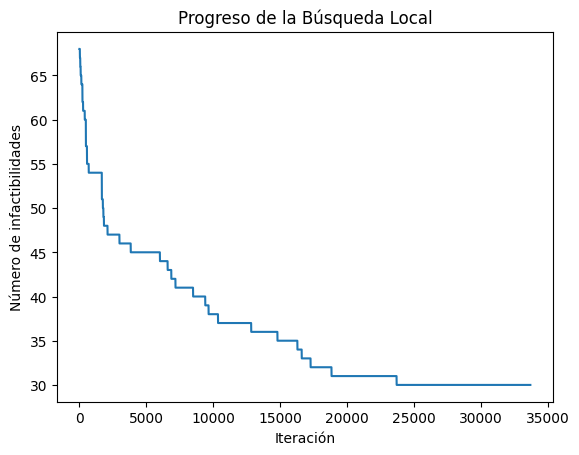

In [27]:
datos = cargar_datos("generic_input_case.xlsx")
random.seed(25)
# Generar solución inicial
solucion_inicial = generar_solucion_inicial(datos)
print(criteria_rev_n(solucion_inicial, 31))
# Aplicar búsqueda local
solucion_mejorada, es_factible, historial = busqueda_local(solucion_inicial, datos, max_iter=100000, max_sin_mejora=10000)

# Verificar resultados
if es_factible:
    print("¡Solución factible encontrada!")
else:
    print(f"Mejor solución encontrada (infactibilidades: {historial[-1]})")

# Visualizar progreso
import matplotlib.pyplot as plt
plt.plot(historial)
plt.xlabel('Iteración')
plt.ylabel('Número de infactibilidades')
plt.title('Progreso de la Búsqueda Local')
plt.show()

In [30]:
def exportar_solucion_a_excel(solucion, datos, nombre_archivo="solucion_transporte.xlsx"):
    """
    Exporta la solución de transporte a un archivo Excel con el formato especificado.
    
    Args:
        solucion: Matriz numpy con la solución [días x UPs x transportadores]
        datos: Diccionario con los datos del problema (contiene información de UPs, transportadores, etc.)
        nombre_archivo: Nombre del archivo Excel a generar
    """
    # Obtener listas ordenadas de UPs, transportadores y días
    ups_list = list(datos['ups'].keys())
    transportadores_list = list(datos['transportadores'].keys())
    dias_horizonte = datos['dias_horizonte']
    
    # Crear lista para almacenar los datos de cada asignación
    datos_exportar = []
    
    # Recorrer la solución para extraer las asignaciones
    for dia_idx in range(solucion.shape[0]):
        for up_idx in range(solucion.shape[1]):
            for t_idx in range(solucion.shape[2]):
                qtd_veiculos = solucion[dia_idx, up_idx, t_idx]
                
                if qtd_veiculos > 0:  # Solo exportar asignaciones con vehículos
                    up_id = ups_list[up_idx]
                    t_nome = transportadores_list[t_idx]
                    up_data = datos['ups'][up_id]
                    
                    # Obtener día y mes del horizonte
                    dia_obj = dias_horizonte[dia_idx]
                    
                    # Agregar fila a los datos
                    datos_exportar.append({
                        'UP': up_id,
                        'FAZENDA': up_data.fazenda,
                        'TRANSPORTADOR': t_nome,
                        'DÍA': dia_obj.dia,
                        'MES': dia_obj.mes,
                        'DB': up_data.db,
                        'RSP': up_data.rsp,
                        'QTD_VEICULOS': qtd_veiculos,
                        'VOLUME': up_data.volume
                    })
    
    # Crear DataFrame con los datos
    df = pd.DataFrame(datos_exportar)
    
    # Ordenar por día, transportador y UP
    df = df.sort_values(['DÍA', 'TRANSPORTADOR', 'UP'])
    
    # Exportar a Excel
    df.to_excel(nombre_archivo, index=False, sheet_name='SOLUCION')
    print(f"Solución exportada correctamente a {nombre_archivo}")
exportar_solucion_a_excel(solucion_mejorada, datos, "sol_seed25_relajadas4-6_infactible.xlsx")

Solución exportada correctamente a sol_seed25_relajadas4-6_infactible.xlsx


In [28]:
criteria_rev_n(solucion_mejorada, 31)

(array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 1]]),
 array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0]))

In [29]:
solucion_mejorada

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 8, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 6, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 9, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [18]:
criteria_rev(solucion_mejorada,31)

(array([[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 0]))